# EDA : Stanford Dogs Dataset 


This notebook contains :
- first exploratory work on the Stanford dog dataset 
- data preparation for dog breed classification including the thirty dog breed
- separation between train and test set 
- dog image extraction and resizing. 

In [2]:

%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import scipy.io
import fnmatch
import pandas as pd 
import cv2 # opencv
import shutil
import random as rand
from common.common_params import data_dir, img_dir, annotation_dir, DEFAULT_TEST_SPLIT
from common.common_plots import * 
from common.common_xml import xml_to_dic
from standford_dog_dataset_annotation_functions import get_imgs_info, extract_and_resize_pipeline, get_dog_picture_box,  get_size_from_bndbox, get_random_image_path_from_breed
from common.common_img_functions import resize_image, crop_image, square_img


## Images per breed
### Number of images per breed 



In [3]:

data = pd.DataFrame()

for folder in os.scandir(img_dir): 
    folder_name = folder.name
    dog_breed = folder.name.split('-')[1]

    if folder.is_dir : 
        cnt = len(fnmatch.filter(os.scandir(folder), "*.*"))
    data = data.append({'dog_breed' : dog_breed, 'folder_name' :folder.name, 'image_count' : cnt },ignore_index=True)

    

In [4]:
total_image_number = int(data["image_count"].sum())
image_number_min = int(data["image_count"].min())
image_number_max = int(data["image_count"].max())
image_number_med = int(data["image_count"].median())
print(f"Standford Dog dataset image number : { total_image_number }")
print(f"with {data.shape[0]} dog breeds, each containing \
from {image_number_min} to {image_number_max} images with a median of {image_number_med} images\n")

Q3 = data['image_count'].quantile(0.75)
Q1 = data['image_count'].quantile(0.25)

nbq75 = data[data['image_count'] > Q3]['image_count'].count()
nbq25 = data[data['image_count'] > Q1]['image_count'].count()

print(f"Number of breed with data above the third quantile ({Q3} number of images): {nbq75}")
print(f"Number of breed with data above the first quantile ({Q1} number of images): {nbq25}")

Standford Dog dataset image number : 20580
with 120 dog breeds, each containing from 148 to 252 images with a median of 159 images

Number of breed with data above the third quantile (186.25 number of images): 30
Number of breed with data above the first quantile (152.75 number of images): 90


In [5]:
selected_breed = data[data['image_count'] > data['image_count'].quantile(0.75)]
selected_breed.to_csv("selected_breed.csv")

### Most represented dog breeds

In [6]:
sorted_data = data.sort_values(by="image_count",ascending=False).head(4)
sorted_data

,dog_breed,folder_name,image_count
2,Maltese_dog,n02085936-Maltese_dog,252.0
9,Afghan_hound,n02088094-Afghan_hound,239.0
26,Scottish_deerhound,n02092002-Scottish_deerhound,232.0
107,Pomeranian,n02112018-Pomeranian,219.0


In [7]:
top_breed_folder_list_30 =  data.sort_values(by="image_count",ascending=False).head(30)["folder_name"].tolist()

In [8]:
np.save(os.path.join(data_dir,"npy","top_breed_folder_list_30.npy"),top_breed_folder_list_30 , allow_pickle=True)


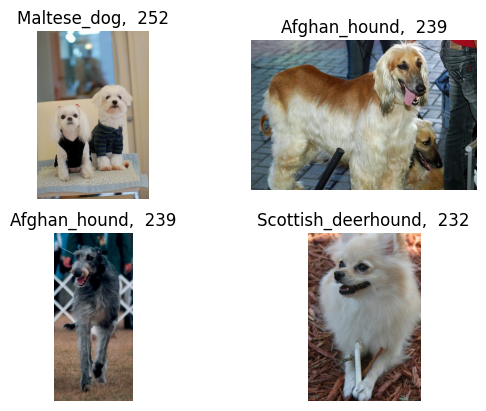

In [9]:
N, M = 2, 2
breed_idx = sorted_data.head(N+M).index
cnt = 0 
img_list = []
titles= []
for i, j in itertools.product(range(N), range(M)):
    dog_info = data.loc[breed_idx[cnt]]
    img_list.append(get_random_image_path_from_breed(data, dog_info['dog_breed'] ))
    titles.append(f"{dog_info['dog_breed']},  {int(dog_info['image_count'])}")
    cnt = cnt + 1 
display_images(img_list, N, M, titles=titles)

## Image sizes

In [10]:
dog_img_size = get_imgs_info(data)
dog_img_size.describe()

,height,width,channels
count,20580.000000,20580.000000,20580.0
mean,385.861224,442.531876,3.0
std,124.863446,142.792308,0.0
min,100.000000,97.000000,3.0
25%,333.000000,361.000000,3.0
50%,375.000000,500.000000,3.0
75%,453.000000,500.000000,3.0
max,2562.000000,3264.000000,3.0


All images are 3 channels, meaning colored images, however they do not have the same size.

[]

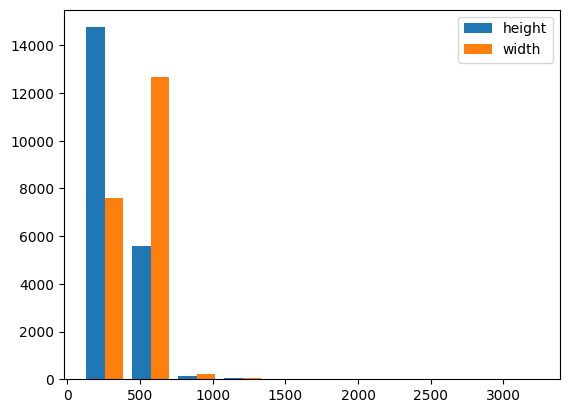

In [ ]:
plt.hist(dog_img_size[["height","width"]],label= ["height","width"])
plt.title("Image sizes from Stanford dog dataset")
plt.legend()
plt.plot()

## Dog image extraction 
## Reading annotation annotation 

In [12]:
img_folder = "n02085620-Chihuahua"
img_test_name = "n02085620_1152"
img_test = f"{img_test_name}.jpg"

In [13]:
test_file = os.path.join(annotation_dir, img_folder, img_test_name)
test_img = os.path.join(img_dir, img_folder, img_test)

In [15]:
test_dic = xml_to_dic(test_file)
cor = get_dog_picture_box(test_dic)
cor

array([{'xmin': '3', 'ymin': '81', 'xmax': '156', 'ymax': '225'},
       {'xmin': '147', 'ymin': '65', 'xmax': '323', 'ymax': '324'},
       {'xmin': '391', 'ymin': '111', 'xmax': '437', 'ymax': '167'}],
      dtype=object)

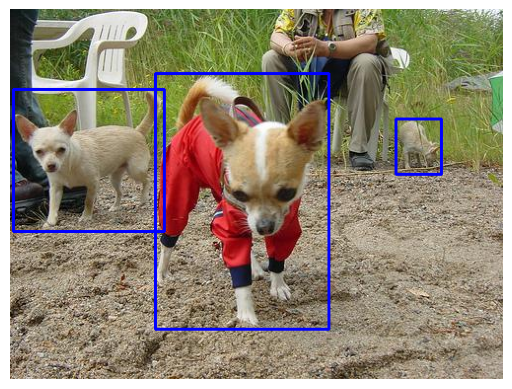

In [16]:
plot_img_with_rectangles_from_path(test_img,cor)

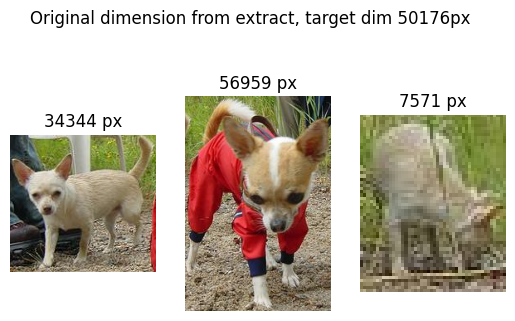

In [17]:
img_list = []
titles = []
for c in cor : 
    nbpixels = get_size_from_bndbox(c)

    img = crop_image(test_img,c)
    img_list.append(img)
    titles.append(f"{nbpixels} px")

display_images(img_list,1,len(cor),
            from_path=False,
            titles=titles,
            main_title=f"Original dimension from extract, target dim {224*224}px")

## Resize to square format: 
try : 
-  Open CV resize function
-  square image by cropping  image from center and then resize
-  square image by cropping image from center **but let a margin** and then resize

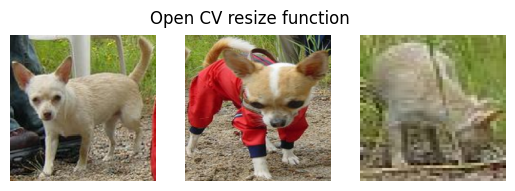

In [18]:

img_list = []
for c in cor : 
    img = crop_image(test_img,c)
    img = resize_image(img, (224,224), from_path=False)
    img_list.append(img)
display_images(img_list, 1, len(cor),
            from_path=False,
            main_title="Open CV resize function")

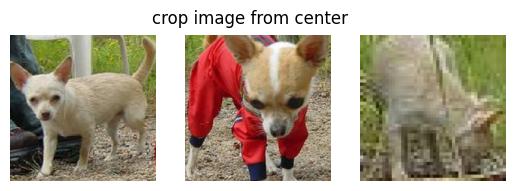

In [19]:
images, nb_img = extract_and_resize_pipeline(test_img, test_file,(224,224))
display_images(images, 1, nb_img,
            from_path=False,
            main_title="crop image from center")

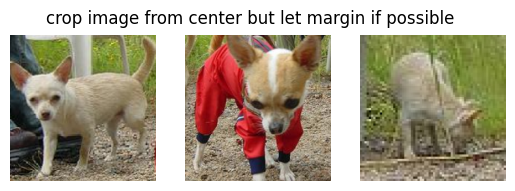

In [20]:
images, nb_img = extract_and_resize_pipeline(test_img, test_file, (224,224), margin=10)
display_images(images, 1, nb_img,
            from_path=False,
            main_title="crop image from center but let margin if possible"
            )

Let's construct new dataset with cropped images with 30 retained classes: 

to avoid **data leakage**, images are separated between test and train and then cropped for dogs present into eah image

In [39]:
source_folder = img_dir
destination_folder = os.path.join(data_dir,"extracted")
if len(os.listdir(destination_folder)) != 0 : 
    [shutil.rmtree(os.path.join(destination_folder,folder)) for folder in destination_folder]
os.mkdir(os.path.join(destination_folder, "train"))
os.mkdir(os.path.join(destination_folder, "test"))
test_check_num = DEFAULT_TEST_SPLIT * 100
TARGET_SIZE = (224, 224)
MARGIN = 10
idx_split = 0 
for breed_folder in os.listdir(source_folder) :
    
    if breed_folder in top_breed_folder_list_30 : 
        
        path = os.path.join(source_folder, breed_folder)
        
        for img_source_name in os.listdir(path) : 
            
            
            img_source_name_core = img_source_name.split('.')[0]
            img_path = os.path.join(source_folder, breed_folder, img_source_name)
            annotation_path = os.path.join(annotation_dir, breed_folder, img_source_name_core)

            assert os.path.exists(annotation_path) , f"annotation path does not exist :  {annotation_path}"
            
            target = "test" if idx_split % test_check_num == 0 else "train"
            idx_split = idx_split + 1 
            # get images of dogs present in an image
            images, nb_img = extract_and_resize_pipeline(img_path, annotation_path, TARGET_SIZE, margin=MARGIN)

            destination_dir = os.path.join(destination_folder, target, breed_folder)
            print(destination_dir)
            if not os.path.exists(destination_dir) :
                os.mkdir(destination_dir)
    
            for i in range(nb_img) : 
                
                destination = os.path.join(destination_dir, f"{img_source_name_core}_{i}.jpg")

                cv2.imwrite(destination, images[i])      
            

C:/dev/image_classification/data/extracted\test\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\test\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/image_classification/data/extracted\train\n02085936-Maltese_dog
C:/dev/i